In [1]:
#Johanna und Markus, Betreuer, Seminar, Martrikelnummer, WiSe 2020, Uni Augsburg

*DISCLAIMER: Dieses Tutorial verwendet das Codefolding Add-On aus Nbextensions. Sollten Sie dieses nicht installiert haben, empfehlen wir das jetzt zu tun, um das Tutorial bestmöglich nutzen zu können.*

*Unter dem folgenden Link finden Sie eine ausführliche Anleitung
https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html.
Achten Sie darauf das Notebook nach den Notebook Server nach der Installation neu zu starten.* 

*Bitte aktivieren Sie die Zeilennummerierung in Ihrem Notebook, indem Sie unter dem Reiter View, "Toogle Line Numbers" auswählen.*

# Tourenplanung für Ride-Sharing-Dienstleister

In [2]:
# Ride Sharing Erklären, Uber Pool

Ein spezielles Tourenplanungsproblem, dass sich mit der Planung von Touren für Ride-Sharing-Dienstleister befasst ist das Dial-a-ride Problem (DARP). Dieses unterscheidet sich von anderen Tourenplanungsproblem zunächst darin, dass sowohl Pickups als auch Dropoffs geplant werden. Außerdem entsteht sich durch das spezielle Förderungsgut "Kunde" eine paarweise Verbindung zwischen Pickups und Dropoffs. Im Gegensatz zu einem homogenen Gut kann ein Drop-off nicht von einem beliebigen Pick-up bedient werden [1]. Zusätzlich ergeben sich durch die Beförderung von Kunden, weitere zu berücksichtigende Kriterien, wie z.B. die im Fahrzeug verbrachte Zeit [2].

Eine Standarddefinition des Problems kommt von Cordeau und Laporte [2]:

<center>"In the dial-a-ride problem (DARP), $n$ users specify transportation requests between given origins and destinations. Users may provide a time window on their desired departure or arrival time, or on both. Transportation is supplied by a fleet of $m$ vehicles based at a common depot. The aim is to design a set of least cost vehicle routes capable of accommodating all requests, under a set of constraints." [2, p.1]</center>

Im Weiteren beschäftigen wir uns mit einer vereinfachten Version des dynamischen DARPs (DDARP), wie es von Haferkamp und Ehmke [3] vorgestellt wird. Da die zukünftigen Kundenanfragen nicht bekannt sind müssen beim Eintreffen jeder einzelnen Anfrage zwei Planungsentscheidung getroffen werden:
  1. Wird der Kunde akzeptiert? 
  2. Und wenn ja, wie sieht eine gute neue Routenplanung aus? #umformulieren
    
Mit einer effizienteren Tourenplanung kann die Akzeptanzrate erhöht werden, die wiederrum in der Regel zu höheren Gewinnen führt. Um das zu erreichen, schlagen Haferkamp und Ehmke vor, Prognosen für zukünftige Kundenanfragen zu erstellen und diese mit in die Planungsentscheidungen einzubeziehen. #schöner

Es werden vier Ausprägungen von Antizipation betrachtet:
1. None Anticipatory/ Myopisch: Zukünftige Kunden werden nicht beachtet und jeder Kunde der in den Tourenplan eingefügt werden kann wird akzeptiert.
2. Anticipatory Acceptance
3. Anticpatory Routing
4. Fully Anticipatory

In Teil 1 beginnen wir mit der detailierten Problemdefinition. Die wir anhand eines Beispiels veranschaulichen. In Teil 2 folgt die Einführung der zwei wesentlichen Methoden, die Large Neighbourhood search (LNS) und die Parallel Insertion Heuristic. Damit kann unser Beispielproblem gelöst werden. Anschließend folgt in Teil 3 ein Ausblick über weitere Anwendungen des DDARPs.

## Teil 1: Ride-Sharing Problem

Zunächst importieren wir die benötigten Libraries.

In [3]:
import sys
from copy import deepcopy
import ipywidgets as widgets
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import plotly.express as px
import pandas as pd
from IPython.display import display

In [4]:
def distance(loc1, loc2):
    return ((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)**0.5

In [5]:
class RideSharing:

    requests = []
    tours = []

    def add_request(self, pickup_loc, dropoff_loc, request_time, max_waiting_duration):
        self.requests.append(Request(pickup_loc, dropoff_loc, request_time, max_waiting_duration))

    def remove_request(self, request):
        if request in self.requests:
            self.requests.remove(request)

    def add_tour(self, depot_loc, latest_return=sys.maxsize):
        self.tours.append(Tour(depot_loc, latest_return))

    def remove_tour(self, tour):
        if tour in self.tours:
            self.tours.remove(tour)

    def solve(self):
        parallel_insertion(self.tours, self.requests)

    def __init__(self):
        pass

In [6]:
class Location:

    def __init__(self, loc, request):
        self.loc = loc
        self.request = request


class PickUp(Location):
    is_pickup = True
    is_dropoff = False

    def __init__(self, loc, request):
        super().__init__(loc, request)


class DropOff(Location):
    is_pickup = False
    is_dropoff = True

    def __init__(self, loc, request):
        super().__init__(loc, request)

In [7]:
class Request:

    count = 0

    def __init__(self, pickup_loc, dropoff_loc, request_time, max_waiting_duration):
        self.id = Request.count
        Request.count += 1
        self.request_time = request_time
        self.max_waiting_duration = max_waiting_duration
        self.latest_dropoff = request_time + distance(pickup_loc, dropoff_loc) + max_waiting_duration
        self.pickup = PickUp(pickup_loc, self)
        self.dropoff = DropOff(dropoff_loc, self)

In [8]:
class Tour:

    def __init__(self, depot_loc=(0, 0), M=sys.maxsize):
        depot = Request(depot_loc, depot_loc, 0, M)
        self.tour = [depot.pickup, depot.dropoff]
        self.early = [0, 0]
        self.late = [M, M]
        self.length = 2
        self.total_cost = 0

    def feasible(self, place, i):
        if place.is_dropoff and place.request.pickup not in self.tour[:i]:
            return False
        if place.is_pickup and place.request.dropoff in self.tour[:i]:
            return False
        e, l = self.insertion_time_window(place, i)
        return e <= l

    def insertion_cost(self, place, i):
        return (distance(self.tour[i-1].loc, place.loc) + distance(place.loc, self.tour[i].loc)
                - distance(self.tour[i-1].loc, self.tour[i].loc))

    # berechne Zeitfenster
    def insertion_time_window(self, place, i):
        # e alt:
        # e = max(place.request.req_t, self.early[i-1] + euclidean(self.tour[i-1].loc, place.loc))
        # e neu:
        e = max(place.request.request_time + distance(self.tour[i-1].loc, place.loc), 
                self.early[i-1] + distance(self.tour[i-1].loc, place.loc))
        l = min(place.request.latest_dropoff, 
                self.late[i] - distance(place.loc, self.tour[i].loc))
        return e, l

    def insert(self, place, i):
        self.total_cost += self.insertion_cost(place, i)
        self.tour.insert(i, place)
        self.length += 1
        self.update(i)
        
    def remove(self, i):
        place = self.tour[i]
        del self.tour[i]
        del self.early[i]
        del self.late[i]
        self.total_cost -= self.insertion_cost(place, i)
        self.length -= 1
        self.recalculate_time_windows()

    def update(self, i):
        # Berechnung und Einfügen des Zeitfensters des neuen Ortes
        e, l = self.insertion_time_window(self.tour[i], i)
        self.early.insert(i, e)
        self.late.insert(i, l)
        # Update der Zeitfenster (late) der vorigen Orte
        for k in range(i-1, -1, -1):
            self.late[k] = min(self.late[k], self.late[k+1] - distance(self.tour[k].loc, self.tour[k+1].loc))
        # Update der Zeitfenster (early) der nachfolgenden Orte
        for k in range(i+1, self.length):
            self.early[k] = max(self.early[k], self.early[k-1] + distance(self.tour[k-1].loc, self.tour[k].loc))
    
    def recalculate_time_windows(self):
        for k in range(1, self.length):
            self.early[k] = max(self.tour[k].request.request_time + distance(self.tour[k-1].loc, self.tour[k].loc), 
                self.early[k-1] + distance(self.tour[k-1].loc, self.tour[k].loc))
        for k in range(self.length-2, -1, -1):
            self.late[k] = min(self.tour[k].request.latest_dropoff, 
                self.late[k+1] - distance(self.tour[k].loc, self.tour[k+1].loc))
        
    def printable(self):
        result= []
        for i in range(self.length):
            if i == 0 or i == self.length-1:
                typ = "Depot"
            elif self.tour[i].is_pickup:
                typ = "Pick-Up"
            else:
                typ = "Drop_Off"
            result.append((self.tour[i].request.id, 
                           self.tour[i].loc, 
                           round(self.early[i], 2), 
                           round(self.late[i], 2), 
                           typ))
        return result

In [9]:
class DecisionEpoch:
    
    # Customers in a vehicle at new request time
    in_vehicle = []
    
    # Customers waiting vor a vehicle at new request time
    waiting = []
    
    def __init__(self, new_request, tours):
        self.time = request.request_time
        self.request = new_request
        self.tours = deepcopy(tours)
        for tour in tours:
            v = len([e for e in self.early if e <= time])
            for i in range(v):
                if tour[i].is_pickup and tour[i].request.dropoff in tour[v:]:
                    self.in_vehicle.append((tour, i))
            for i in range(v, tour.length):
                if tour[i].is_pickup and tour[i].request.dropoff in tour[i:]:
                    self.waiting.append((tour, i))
        self.accept, self.solution = LNS(self, "accept")
        if self.accept:
            pass

Die Kunden steigen im PickUp Punkt in das Fahrzeug ein und am DropOff Punkt wieder aus. Dabei hat jeder Kunde ein Zeitfenster, in dem er bedient werden muss, wenn er angenommen wird. Das Zeitfenster beginnt mit dem Zeitpunkt der Anfrage. Das Ende des Zeitfensters lässt sich errechnen aus der Fahrzeit zwischen den PickUp und dem DropOff plus einem Puffer $\alpha$. Ist $\alpha$ gleich 10, bedeutet das für den Kunden eine mögliche Warte- oder Verzögerungszeit von insgesamt 10 Minuten.  Die Fahrzeit entspricht hier der euklidischen Distanz. Die Attribute der Kunden werden in der Klasse *Requests* festgehalten.

$R$:  requests ($r \in R$)

- receiving time $t_r$
- origin $o_r \in L$
- destination $d_r \in L$
- time window $[b_r, e_r]$
    - $b_r = t_r$
    - $e_r = t_r + c_{o_r,d_r} + \alpha$

$L$:  locations ($l \in L$)

- *loc:* Koordinaten der Location
- *request:* Zugehöriges Request zur Location

$o_r$: origins ($o_r \in L_o \subset L$)

- erbt von Location

$d_r$: destinations ($d_r \in L_d \subset L$)

- erbt von Location

Wir betrachten 5 Kunden, die an den Koordinaten (1,8), (6,5), (3,2), (8,3) zu- und an den Koordinaten (5,9), (3,4), (8,5) und (4,6) aussteigen. Führen Sie den folgenden Code aus um einen Überblick der Anfangskoordinaten (blau) und Endkoordinaten (rot) zu generieren.

In [10]:
instance = RideSharing()
instance.add_tour((1, 1))
instance.add_tour((6, 6))
instance.add_request((1, 8), (5, 9), 1, 10)
instance.add_request((6, 5), (3, 4), 0, 10)
instance.add_request((3, 2), (8, 5), 0, 10)
instance.add_request((8, 3), (4, 6), 0, 10)
#instance.solve()

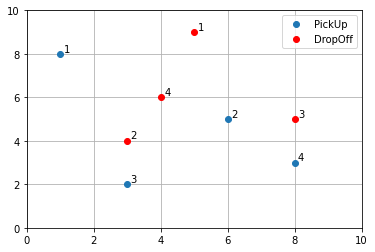

In [11]:
# PickUp und DropOff der Kunden
plt.plot([1,6,3,8],[8,5,2,3],'o', label ="PickUp")
plt.plot([5,3,8,4],[9,4,5,6],'ro', label = "DropOff")
plt.text((1+0.1),(8+0.1), 1)
plt.text((5+0.1),(9+0.1), 1)
plt.text((6+0.1),(5+0.1), 2)
plt.text((3+0.1),(4+0.1), 2)
plt.text((3+0.1),(2+0.1), 3)
plt.text((8+0.1),(5+0.1), 3)
plt.text((8+0.1),(3+0.1), 4)
plt.text((4+0.1),(6+0.1), 4)
plt.axis([0,10,0,10])
plt.grid()
plt.legend()
plt.show()

Kunde | PickUp  | DropOff | Request Time | End Time | alpha
--|:---------:|:---------:|:---------:|:---------:|:---------:
1|(1,8)    | (5,9)   |0|| 10 
2|(6,5)   | (3,4) |1||10
3|(3,2)   | (8,5) |2||10
4|(8,3)   | (4,6) |3||10


In [16]:
#Kunde Nr. 5 hinzufügen

style = {'description_width': 'initial'}
xo = widgets.BoundedIntText(value=4, min=0, max=10,step=1,description='X-Koordinate PickUp',disabled=False, style=style)
yo = widgets.BoundedIntText(value=7, min=0, max=10,step=1,description='Y-Koordinate PickUp',disabled=False, style=style)
xd = widgets.BoundedIntText(value=6, min=0, max=10,step=1,description='X-Koordinate DropOff',disabled=False, style=style)
yd = widgets.BoundedIntText(value=1, min=0, max=10,step=1,description='Y-Koordinate DropOff',disabled=False, style=style)
rt = widgets.BoundedIntText(value=3, min=0, max=10,step=1,description='Request Time',disabled=False, style=style)

button = widgets.Button(description="Hinzufügen")


def on_button_clicked(b):
    instance.add_request((xo.value, yo.value), (xd.value, yd.value), rt.value, 10)

button.on_click(on_button_clicked)

display( xo, yo, xd, yd, rt,  button)


BoundedIntText(value=4, description='X-Koordinate PickUp', max=10, style=DescriptionStyle(description_width='i…

BoundedIntText(value=7, description='Y-Koordinate PickUp', max=10, style=DescriptionStyle(description_width='i…

BoundedIntText(value=6, description='X-Koordinate DropOff', max=10, style=DescriptionStyle(description_width='…

BoundedIntText(value=1, description='Y-Koordinate DropOff', max=10, style=DescriptionStyle(description_width='…

BoundedIntText(value=3, description='Request Time', max=10, style=DescriptionStyle(description_width='initial'…

Button(description='Hinzufügen', style=ButtonStyle())

## Teil 2: Heuristisches Lösungverfahren für das DDRAP

### Insertion-Heuristik

In [13]:
def parallel_insertion(tours, requests, M=sys.maxsize):
    reject = []
    # Kunden = copy.deepcopy(fiktivekunden)
    
    while requests: # Braucht man hier nicht =/= []?
        pOpt = M 
        for j in range(len(requests)):
            for k in range(len(tours)):
                # spos: Position in Tour k, an der der Pickup des Kunden eingefügt wird
                for spos in range(1, tours[k].length):
                    if tours[k].feasible(requests[j].origin, spos):
                        skosten = tours[k].insertion_cost(requests[j].origin, spos)
                        
                        # speichert die aktuell gültige Tour in einer temporären Variablen
                        tour_temp = deepcopy(tours[k])
                        
                        # füge den Pickup des Kunden vorübergehend in den Tourenplan ein und Update der Zeitfenster
                        tour_temp.insert(requests[j].origin, spos)
                        
                        # Prüfe für alle Positionen im Tourenplan nach dem eingefügten Pickup ob es einen möglichen Drop-off gibt 
                        for epos in range(spos+1, tour_temp.length): 
                            if tour_temp.feasible(requests[j].destination, epos):  
                                ekosten = tour_temp.insertion_cost(requests[j].destination, epos)
                                if skosten + ekosten < pOpt:
                                    reqOpt = requests[j] 
                                    tourOpt = tours[k] 
                                    sposOpt = spos
                                    eposOpt = epos
                                    pOpt = skosten + ekosten   
      
        if pOpt < M:   
            # Setze den Pickup und Drop-Off des Kunden ein und aktualisiere Zeitfenster
            tourOpt.insert(reqOpt.origin, sposOpt)
            tourOpt.insert(reqOpt.destination, eposOpt)
            
            #Entferne den eigesetzten Kunden aus der Liste der noch ausstehenden Kunden
            requests.remove(reqOpt)         
        else:
            # Wenn kein Kunde den Feasibility mehr besteht, speichere die abgewiesenen Kunden und leere die Liste
            reject = deepcopy(requests)
            requests = []
   
    return tours, reject

In [14]:
tours, reject = parallel_insertion([tour1, tour2], [kunde1, kunde2, kunde3])
for tour in tours:
    # ID, Location, (früheste) Besuchszeit, Origin/Destination
    print(tour.printable())

NameError: name 'tour1' is not defined

$K$:  Entscheidungsepochen ($k \in K$)

In [ ]:
t = Tour()

pickup = Origin((5,4), ())
t.insertion_time_window(pickup, 0)

### GANTT CHART

In [ ]:
def convert_to_datetime(x):
      return datetime.fromtimestamp(31536000+x*24*3600).strftime("%Y-%m-%d")

In [ ]:
#Kunden ID: I; Untere schranke Zeitfenster: start; obere Schranke Zeitfenster: ende
I = [1,3,3,3] #instance.requests[i].id
start = [0,1,5,7] #instance.requests[i].request_time
ende = [4,4,6,8] #instance.requests[i].latest_dropoff

In [ ]:
for j in range(len(start)):
    start[j] = convert_to_datetime(start[j])
    ende[j] = convert_to_datetime(ende[j])

In [ ]:
num_tick_labels = np.linspace(start = 0, stop = 10, num = 21, dtype = int)
date_ticks = [convert_to_datetime(x) for x in num_tick_labels]

In [ ]:
df = pd.DataFrame({'Kunde': I, "Start": start , "Finish": ende})

In [ ]:
df

In [ ]:
fig = px.timeline(df, x_start='Start', x_end='Finish', y='Kunde')
fig.layout.xaxis.update({
        'tickvals' : date_ticks,
        'ticktext' : num_tick_labels
        })
fig.update_yaxes(autorange="reversed")
fig.show()

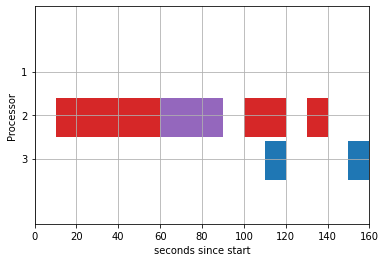

In [19]:
# Declaring a figure "gnt" 
fig, gnt = plt.subplots() 
  
# Setting Y-axis limits 
gnt.set_ylim(0, 50) 
  
# Setting X-axis limits 
gnt.set_xlim(0, 160) 
  
# Setting labels for x-axis and y-axis 
gnt.set_xlabel('seconds since start') 
gnt.set_ylabel('Processor') 
  
# Setting ticks on y-axis 
gnt.set_yticks([15, 25, 35]) 
# Labelling tickes of y-axis 
gnt.set_yticklabels(['3', '2', '1']) 
  
# Setting graph attribute 
gnt.grid(True) 
  
# Declaring a bar in schedule 
gnt.broken_barh([(40, 50)], (20, 9), facecolors =('tab:purple')) 
  
# Declaring multiple bars in at same level and same width 
gnt.broken_barh([(110, 10), (150, 10)], (10, 9), facecolors ='tab:blue') 
  
gnt.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9), facecolors =('tab:red')) 
  
#plt.savefig("gantt1.png") 

## Teil 3: Ausblick

## Literaturverzeichnis:

[1] Parragh, S. N., Doerner, K. F., & Hartl, R. F. (2008). A survey on pickup and delivery problems. Part II:
Transportation between pickup and delivery locations. Journal für Betriebswirtschaft, 58(2), 81–117.

[2] Cordeau, J.-F., & Laporte, G. (2003). A tabu search heuristic for the static multi-vehicle dial-a-ride problem.
Transportation Research Part B: Methodological, 37(6), 579–594.

[3 ]Haferkamp J, Ehmke J (2020): Evaluation of Anticipatory Decision-Making in
Ride-Sharing Services. Working Paper, Universität Magdeburg.